<a href="https://colab.research.google.com/github/nimashafiei/Lung-Segmentation/blob/main/Lung_Segmentation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [1]:
!pip install pydicom

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.0/2.0 MB 20.0 MB/s eta 0:00:00


In [20]:
import numpy as np
import pydicom
import os
import matplotlib.pyplot as plt
from glob import glob
import scipy.ndimage
from skimage import morphology
from skimage import measure
from skimage.transform import resize
from sklearn.cluster import KMeans
import cv2

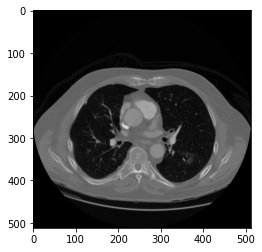

In [21]:
img = pydicom.dcmread('Data/1.dcm').pixel_array
    
img_2d = img.astype(float)

image_2d_scaled = (np.maximum(img_2d,0) / img_2d.max()) * 255.0

image_2d_scaled = np.uint8(image_2d_scaled)

plt.imshow(image_2d_scaled, cmap='gray')

In [22]:
# Get the image dimensions
rows, cols = img.shape[:2]

In [23]:
# Normalize the pixel values
img = (img - np.mean(img)) / np.std(img)

In [24]:
# Renormalize the image near the lungs
lung_area = img[rows // 5:4 * rows // 5, cols // 5:4 * cols // 5] 
mean_lung = np.mean(lung_area)  
max_val = np.max(img)
min_val = np.min(img)
img[img == max_val] = mean_lung
img[img == min_val] = mean_lung

In [25]:
# Perform K-means clustering to separate foreground and background
kmeans = KMeans(n_clusters=2).fit(np.reshape(lung_area, [-1, 1]))
centers = sorted(kmeans.cluster_centers_.flatten())
threshold = np.mean(centers)
binary_img = np.where(img < threshold, 1.0, 0.0)

/usr/local/lib/python3.9/dist-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


In [26]:
# Erode and dilate the binary image to remove small elements and fill in gaps
eroded = morphology.erosion(binary_img, np.ones([3, 3]))
dilated = morphology.dilation(eroded, np.ones([5, 5]))

In [27]:
# Label the connected components and select those that correspond to the lungs
labels = measure.label(dilated)
regions = measure.regionprops(labels)
good_labels = [prop.label for prop in regions                if prop.bbox[2] - prop.bbox[0] < rows / 10 * 9 
               and prop.bbox[3] - prop.bbox[1] < cols / 10 * 9 
               and prop.bbox[0] > rows / 5 
               and prop.bbox[2] < cols / 5 * 4]
lung_mask = np.zeros([rows, cols], dtype=np.int8)
for label in good_labels:
    lung_mask += np.where(labels == label, 1, 0)
lung_mask = morphology.dilation(lung_mask, np.ones([10, 10]))

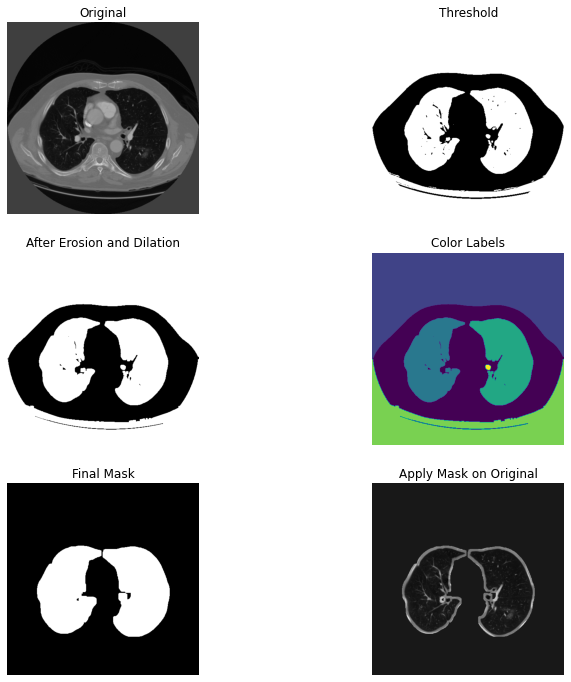

In [28]:
# Display the intermediate and final results

fig, axes = plt.subplots(3, 2, figsize=[12, 12])
axes[0, 0].set_title("Original")
axes[0, 0].imshow(img, cmap='gray')
axes[0, 0].axis('off')
axes[0, 1].set_title("Threshold")
axes[0, 1].imshow(binary_img, cmap='gray')
axes[0, 1].axis('off')
axes[1, 0].set_title("After Erosion and Dilation")
axes[1, 0].imshow(dilated, cmap='gray')
axes[1, 0].axis('off')
axes[1, 1].set_title("Color Labels")
axes[1, 1].imshow(labels)
axes[1, 1].axis('off')
axes[2, 0].set_title("Final Mask")
axes[2, 0].imshow(lung_mask, cmap='gray')
axes[2, 0].axis('off')
axes[2, 1].set_title("Apply Mask on Original")
axes[2, 1].imshow(lung_mask * img, cmap='gray')
axes[2, 1].axis('off')

plt.show()